# Relax - Takehome Challenge
## Goal: Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption.

In [193]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [197]:
# read csvs
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=True, index_col='time_stamp')
users = pd.read_csv('takehome_users.csv', encoding='latin-1',  parse_dates=True)

# convert unix timestamps to datetime objects
users['last_session_creation_time'] =  pd.to_datetime(users['last_session_creation_time'], unit='s')

# convert strings to datetime objects
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [198]:
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [199]:
engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [200]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [201]:
users.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,0.432742,0.356432,124.056723,3383.761968
min,1.00000,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


In [202]:
# Drop username and emails - no reason to keep
users = users.drop(['name', 'email'], axis=1)

In [203]:
# Convert 'invited_by_user_id' column to be 0 if a user was not invited by another user, 1 otherwise
users['invited_by_user_id'] = [0 if np.isnan(row[1]) else 1 for row in users['invited_by_user_id'].iteritems()]

# Convert 'last_session_creation_time' column to be 0 if a user has not had an active session, 1 otherwise
users['last_session_creation_time'] = [0 if row[1] != row[1] else 1 for row in users['last_session_creation_time'].iteritems()]

In [204]:
users.head(10)

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1,1,0,11,1
1,2,2013-11-15 03:45:04,ORG_INVITE,1,0,0,1,1
2,3,2013-03-19 23:14:52,ORG_INVITE,1,0,0,94,1
3,4,2013-05-21 08:09:28,GUEST_INVITE,1,0,0,1,1
4,5,2013-01-17 10:14:20,GUEST_INVITE,1,0,0,193,1
5,6,2013-12-17 03:37:06,GUEST_INVITE,1,0,0,197,1
6,7,2012-12-16 13:24:32,SIGNUP,1,0,1,37,0
7,8,2013-07-31 05:34:02,PERSONAL_PROJECTS,0,1,1,74,0
8,9,2013-11-05 04:04:24,PERSONAL_PROJECTS,0,0,0,302,0
9,10,2013-01-16 22:08:03,ORG_INVITE,1,1,1,318,1


In [205]:
# Convert 'creation_source' column to be 5 different columns for each creation_source category
creation_columns = pd.get_dummies(users['creation_source'], prefix='creation_source')

In [206]:
# Add the creation_source columns to the original df and drop original column
users = pd.concat([users, creation_columns], axis=1)
users = users.drop('creation_source', axis=1)

In [208]:
# Convert creation_time column to be an integer of seconds since the first user was created
users['creation_time'] = (users['creation_time'] - min(users['creation_time'])).dt.total_seconds()

In [209]:
# initialize adopted mapping dictionary
adopted = {}

# for each user in users
for user_id in tqdm(set(users['object_id'].values)):
    
    # For each 7 day window, calculate the number of logins
    logins = engagement[engagement['user_id'] == user_id].sort_values('time_stamp').rolling(window='7D').sum()
    
    # if logins in a 7 day window >= 3, user is adopted, else no
    if not logins.empty:
        if (logins['visited'].sort_values(ascending=False)[0] >= 3) & (not logins.empty):
            adopted[user_id] = 1
        else:
            adopted[user_id] = 0
    else:
        adopted[user_id] = 0
        
# map adopted values to users df as target variable
users['adopted'] = users['object_id'].map(adopted)

In [221]:
# import sklearn functions
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [212]:
users.head()

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,adopted
0,1,59713803.0,1,1,0,11,1,1,0,0,0,0,0
1,2,46062097.0,1,0,0,1,1,0,1,0,0,0,1
2,3,25309885.0,1,0,0,94,1,0,1,0,0,0,0
3,4,30698761.0,1,0,0,1,1,1,0,0,0,0,0
4,5,19992653.0,1,0,0,193,1,1,0,0,0,0,0


In [213]:
# set X and y arrays
X = users.drop(['object_id', 'adopted'], axis=1)
y = users['adopted']

In [216]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=1000,
                              random_state=42)\

forest.fit(X, y)
importances = forest.feature_importances_

Feature ranking:
1. feature 0 (0.499917)
2. feature 4 (0.415587)
3. feature 1 (0.055566)
4. feature 2 (0.009816)
5. feature 3 (0.008228)
6. feature 8 (0.003418)
7. feature 6 (0.002322)
8. feature 10 (0.001459)
9. feature 9 (0.001423)
10. feature 7 (0.001272)
11. feature 5 (0.000993)


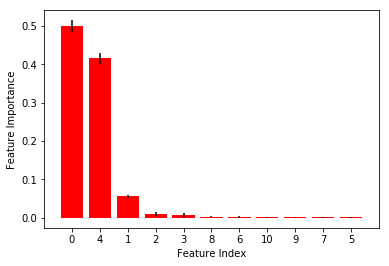

In [238]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()

In [218]:
for idx, column in enumerate(X.columns):
    print('Feature', idx, ': ', column)

Feature 0 :  creation_time
Feature 1 :  last_session_creation_time
Feature 2 :  opted_in_to_mailing_list
Feature 3 :  enabled_for_marketing_drip
Feature 4 :  org_id
Feature 5 :  invited_by_user_id
Feature 6 :  creation_source_GUEST_INVITE
Feature 7 :  creation_source_ORG_INVITE
Feature 8 :  creation_source_PERSONAL_PROJECTS
Feature 9 :  creation_source_SIGNUP
Feature 10 :  creation_source_SIGNUP_GOOGLE_AUTH


In [229]:
y.value_counts()

0    10398
1     1602
Name: adopted, dtype: int64